In [1]:
import os

import h5py
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.chdir('/home/ron/Documents/DenseSeg')

In [4]:
data = torch.load('dataset/data/graz/lms_dsc_800.pth', map_location=device)
#data.keys()
h5_file = h5py.File('dataset/data/graz/graz_prediction_800split.h5', 'r')

In [5]:
csv_path = 'dataset/data/graz/dataset_with_cv_split.csv'

#csv_path = 'storage/staff/ronkeuth/SemiSAM/data/dataset.csv'
df_meta = pd.read_csv(csv_path, index_col='filestem')

train_test = torch.zeros(4830)
for i in trange(4830):
    f = data['keys'][i]
    train_test[i] = df_meta.loc[f,'cv_test_idx']
#    cv = df_meta[f]['cv_test_idx']

  0%|          | 0/4830 [00:00<?, ?it/s]

In [6]:
train_idx = torch.nonzero((train_test-1).abs()==1).squeeze()
test_idx = torch.nonzero((train_test-1).abs()!=1).squeeze()
train_idx.shape,test_idx.shape

(torch.Size([2913]), torch.Size([1917]))

In [7]:
lms_in = data['lms']

In [8]:
lms_len = torch.zeros(17).long()
for i in range(len(lms_in[0])):
    lms_len[i] = (len(lms_in[0][i]))
print(lms_len)

tensor([40, 20, 35, 25, 30, 30, 30, 30, 25, 30, 50, 50, 50, 50, 60, 80, 75])


In [9]:
lms_len_cum = torch.cat((torch.zeros(1),lms_len.cumsum(0))).long()
lms_len_cum

tensor([  0,  40,  60,  95, 120, 150, 180, 210, 240, 265, 295, 345, 395, 445,
        495, 555, 635, 710])

In [10]:
lms_est = torch.zeros(4830,80,2,17)
for i in trange(4830):
    if(i==2347):
        f = data['keys'][i+1]
    else:
        f = data['keys'][i]
    
    lms_est_in = torch.from_numpy(np.array(h5_file[f]['lms'])).flip(-1)
    for j in range(17):
        lms_est[i,:lms_len[j],:,j] = (lms_est_in[lms_len_cum[j]:lms_len_cum[j+1]])
lms_est = lms_est.to(device).view(-1,160,17)      
#len(data['lms'][0][1]),len(data['lms'][0][2])

  0%|          | 0/4830 [00:00<?, ?it/s]

In [12]:
lms = torch.zeros(4830,80,2,17)
for i in trange(4830):
    for j in range(17):
        lms[i,:lms_len[j],:,j] = (lms_in[i][j])
lms = lms.to(device).view(-1,160,17)      
#len(data['lms'][0][1]),len(data['lms'][0][2])

  0%|          | 0/4830 [00:00<?, ?it/s]

In [13]:
lms1 = torch.ones(4830,lms_len.sum(),3)
for i in trange(4830):
    for j in range(17):
        lms1[i,lms_len_cum[j]:lms_len_cum[j+1],:2] = (lms_in[i][j])
lms1 = lms1.to(device)#.view(-1,160,17)      
#len(data['lms'][0][1]),len(data['lms'][0][2])

  0%|          | 0/4830 [00:00<?, ?it/s]

In [14]:
ages1 = torch.zeros(4830)
for i in trange(4830):
    f = data['keys'][i]
    ages1[i] = df_meta.loc[f,'age']*12


  0%|          | 0/4830 [00:00<?, ?it/s]

In [15]:
(ages1.sort().values//4).max()

tensor(55.)

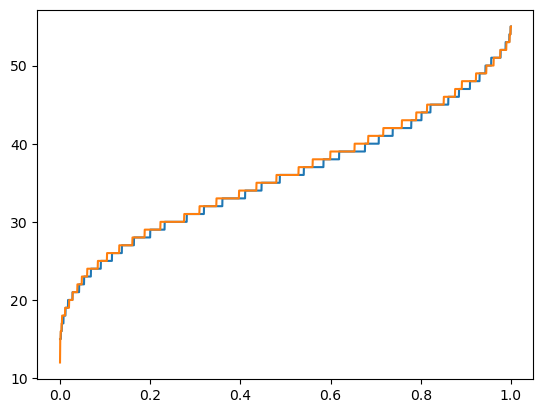

In [16]:
plt.plot(torch.linspace(0,1,len(train_idx)),ages1[train_idx].sort().values//4)
plt.plot(torch.linspace(0,1,len(test_idx)),ages1[test_idx].sort().values//4)

In [17]:

from torch import nn
from torcheval.metrics.functional import r2_score,multiclass_confusion_matrix,multiclass_accuracy,multiclass_auroc,multiclass_f1_score
labels_val = (ages1[test_idx]/4).long().cpu()
labels_val4 = (ages1[test_idx]).float().cpu()

n_classes = 57

In [18]:
lms_dm = torch.zeros_like(lms)
for i in range(17):
    input = lms.view(-1,80,2,17)[...,i][:,:lms_len[i]].clone()
    input -= input.mean(1,keepdim=True)
    lms_dm.view(-1,80,2,17)[:,:lms_len[i],:,i] = input 

In [19]:
lms_est_dm = torch.zeros_like(lms)
for i in range(17):
    input = lms_est.view(-1,80,2,17)[...,i][:,:lms_len[i]].clone()
    input -= input.mean(1,keepdim=True)
    lms_est_dm.view(-1,80,2,17)[:,:lms_len[i],:,i] = input 

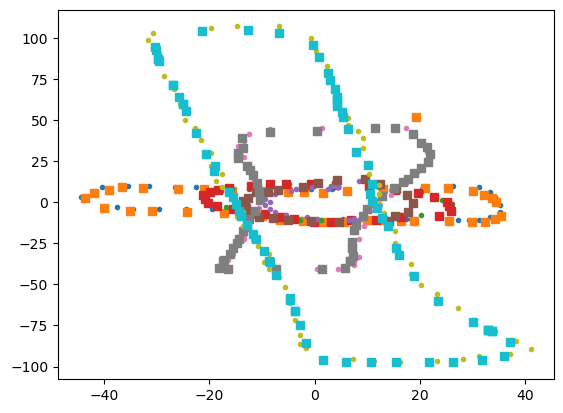

In [20]:
for i in range(0,17,4):
    plt.plot(lms_dm[0].view(80,2,17)[...,i][:lms_len[i],1].data.cpu(),lms_dm[0].view(80,2,17)[...,i][:lms_len[i],0].data.cpu(),'.')
    plt.plot(lms_est_dm[0].view(80,2,17)[...,i][:lms_len[i],1].data.cpu(),lms_est_dm[0].view(80,2,17)[...,i][:lms_len[i],0].data.cpu(),'s')
    

  0%|          | 0/2500 [00:00<?, ?it/s]

/home/ron/mambaforge/envs/DenseBone/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


  0%|          | 0/64 [00:00<?, ?it/s]

accuracy=0.099, AUROC=0.722, F1-score=0.099
R2=0.681 MAE=14.724


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

accuracy=0.097, AUROC=0.730, F1-score=0.097
R2=0.699 MAE=14.181


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

accuracy=0.097, AUROC=0.734, F1-score=0.097
R2=0.717 MAE=13.911


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

accuracy=0.100, AUROC=0.737, F1-score=0.100
R2=0.721 MAE=13.870


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

accuracy=0.099, AUROC=0.739, F1-score=0.099
R2=0.728 MAE=13.666


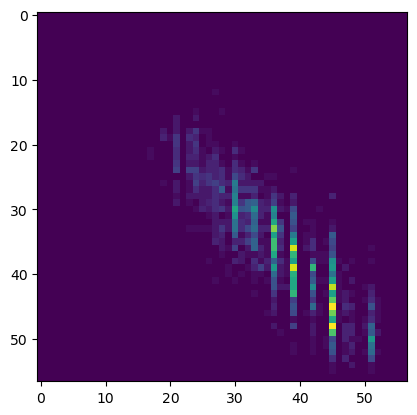

In [28]:
prediction1 = torch.zeros(len(test_idx),57)#.cuda()
ensemble_prediction = torch.empty(5, len(test_idx), 57).to(device)
base = 32#256//2
for i, e in enumerate(range(5)):
    mlp = nn.Sequential(nn.Conv1d(160,base,1),nn.BatchNorm1d(base),nn.ReLU(),\
                         nn.Conv1d(base,base,1),nn.BatchNorm1d(base),nn.ReLU(),\
                         nn.Conv1d(base,base//4,1),nn.BatchNorm1d(base//4),nn.ReLU(),nn.Flatten(1,),\
                       nn.Linear(base//4*17,base*2),nn.ReLU(),nn.Linear(base*2,base),nn.ReLU(),nn.Linear(base,57)).to(device)
    #with torch.no_grad():
    #    output = mlp(lms[:32])


    optimizer = torch.optim.Adam(mlp.parameters(),lr=0.001)
    run_loss = torch.zeros(2500)
    for i in trange(2500):
        optimizer.zero_grad()
        #idx = torch.randperm(len(segs1)-1000)[:64]
        idx = train_idx[torch.randperm(len(train_idx))[:64]]
        with torch.cuda.amp.autocast(dtype=torch.bfloat16):
            with torch.no_grad():
                affine = (torch.eye(2,3).unsqueeze(0)+torch.randn(64*17,2,3)*.05).to(device)
                if(i%2==0):
                    input = torch.cat((lms_dm[idx].view(-1,80,2,17).permute(0,3,1,2).reshape(64*17,-1,2),torch.ones(64*17,80,1).to(device)),2)
                else:
                    input = torch.cat((lms_est_dm[idx].view(-1,80,2,17).permute(0,3,1,2).reshape(64*17,-1,2),torch.ones(64*17,80,1).to(device)),2)
                
                input = input.bmm(affine.permute(0,2,1)).reshape(64,17,80,2).permute(0,2,3,1).reshape(64,160,17)
                mask = lms[idx]!=0
                input *= mask.float()
            #input = F.grid_sample(segs1[idx].cuda().float(),affine,padding_mode='border',mode='nearest')
            output = mlp(input)#

            loss = nn.CrossEntropyLoss()(output,(ages1[idx]/4).long().to(device))
            loss.backward()
        optimizer.step()
        run_loss[i] = loss.item()

    mlp.eval()
    with torch.no_grad():
        #start_c = len(segs1)-1000
        for cc in tqdm(torch.chunk(torch.arange(len(test_idx)),64)):
            c = test_idx[cc]
            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                output = mlp(lms_est_dm[c].to(device).float())
                prediction1[cc]  += output.cpu()
    argmax1 = (prediction1.argmax(1))
    ensemble_prediction[e] = prediction1

    print('accuracy=%0.3f'%(multiclass_accuracy(prediction1,labels_val).item())+', AUROC=%0.3f'%(multiclass_auroc(prediction1,labels_val,num_classes=n_classes).item())+\
              ', F1-score=%0.3f'%(multiclass_f1_score(prediction1,labels_val).item()))
    print('R2=%0.3f'%(r2_score(argmax1.float().cpu()*4,labels_val4.cpu())).item()+' MAE=%0.3f'%(nn.L1Loss()(argmax1.float().cpu()*4,labels_val4.cpu())).item())
plt.imshow(multiclass_confusion_matrix(prediction1,labels_val,n_classes).data.cpu())
plt.show()


In [29]:
ensemble_prediction = ensemble_prediction.mean(0)
ensemble_argmax = ensemble_prediction.argmax(1)
print('accuracy=%0.3f'%(multiclass_accuracy(ensemble_prediction,labels_val).item())+', AUROC=%0.3f'%(multiclass_auroc(ensemble_prediction,labels_val,num_classes=n_classes).item())+\
              ', F1-score=%0.3f'%(multiclass_f1_score(ensemble_prediction,labels_val).item()))
print('R2=%0.3f'%(r2_score(ensemble_argmax.float().cpu()*4,labels_val4.cpu())).item()+' MAE=%0.3f'%(nn.L1Loss()(ensemble_argmax.float().cpu()*4,labels_val4.cpu())).item())

accuracy=0.099, AUROC=0.736, F1-score=0.099
R2=0.719 MAE=13.837


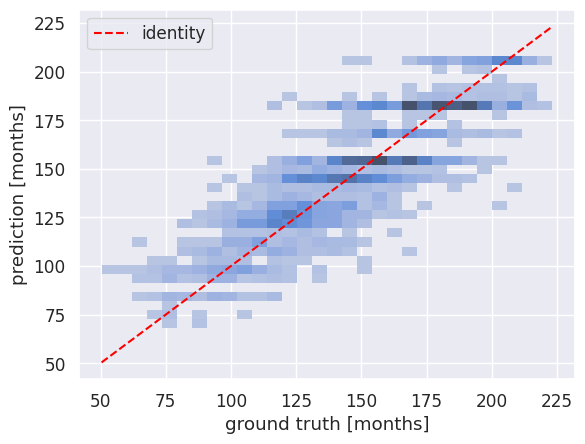

In [39]:
import seaborn as sns
# increase plot font size
sns.set(font_scale=1.1)

df_result = pd.DataFrame({'ground truth [months]':labels_val4.cpu().numpy(),'prediction [months]':ensemble_argmax.float().cpu().numpy()*4})
sns.histplot(data=df_result, x="ground truth [months]", y="prediction [months]", bins=30)
line_pnts = [df_result['ground truth [months]'].min(), df_result['ground truth [months]'].max()]
plt.plot(line_pnts, line_pnts, color='red', linestyle='--')
plt.legend(['identity'])
plt.savefig('/home/ron/Documents/Konferenzen/IJCARS/results/age_prediction_graz.pdf', bbox_inches='tight', pad_inches=0)

In [25]:
nn.L1Loss()(labels_val.float().mean().cpu()*4,labels_val.cpu()*4)

/home/ron/mambaforge/envs/DenseBone/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1917])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(27.4031)

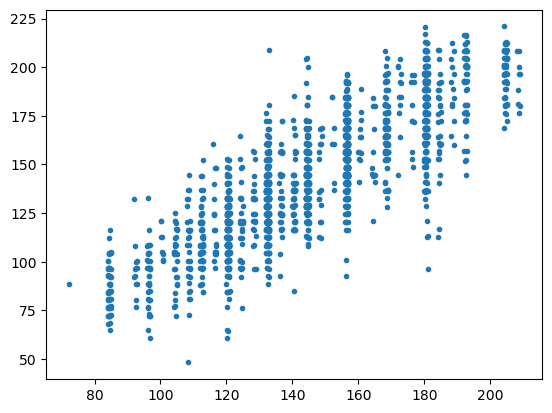

In [26]:
plt.plot(torch.rand(len(test_idx))*1+argmax1.float().cpu()*4,torch.rand(len(test_idx))*1+labels_val.cpu()*4,'.')


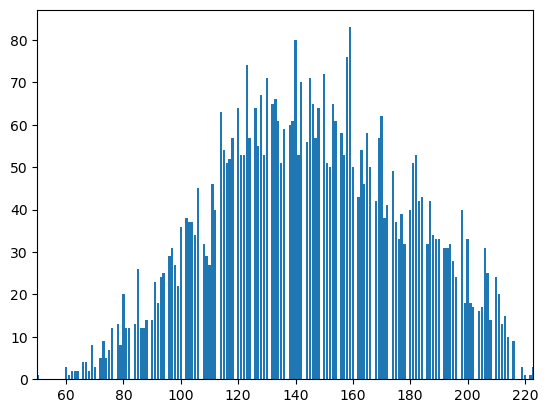

In [27]:
hist_valid = torch.bincount(ages1.long())
#ages_all = torch.from_numpy(np.array(ages)).float()
#hist_all = torch.bincount(ages_all.long())

plt.bar(torch.arange(len(hist_valid)),hist_valid)
plt.xlim([ages1.long().min(),ages1.long().max()])
plt.show()
#plt.bar(torch.arange(len(hist_all)),hist_all)
#plt.xlim([ages1.long().min(),ages1.long().max()])